In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from brian2 import *
from scipy.stats import circstd,circmean
from scipy.ndimage.filters import gaussian_filter
from collections import *
from matplotlib.pyplot import *

In [2]:
path_to_files='../fig_carrier_pop/carrier_pop_data_files/'
tau_b=np.load(path_to_files+'tau_b.npy')
sigma_k=np.load(path_to_files+'sigma_k.npy')
gamma=np.load(path_to_files+'gamma.npy')
k=np.load(path_to_files+'k.npy')
m=np.load(path_to_files+'m.npy')
dict_param=OrderedDict([('tau_b',tau_b),('sigma_k',sigma_k),('gamma',gamma),('k',k),('m',m)])
latex_param_names=OrderedDict([('tau_b',r'$\tau_{b}$'),('sigma_k',r'$\sigma_{k}$'),('gamma',r'$\gamma$'),('k',r'$k$'),('m',r'$m$')])

In [3]:
def mean_over_phi_start_carriers(filename_ipd,carrier):
    path='../fig_carrier_pop/carrier_pop_data_files/'
    res=load(path+filename_ipd)
    nbr_param_sets=int(res.size/(res.shape[0]*res.shape[6]))
    res_flat=res.reshape((res.shape[0],nbr_param_sets,res.shape[6]))
    res_flat_average=np.zeros((res.shape[0],nbr_param_sets))
    sd_flat=np.zeros((res.shape[0],nbr_param_sets))
    cp_nan=0
    for i in range(nbr_param_sets):
        if not np.all(res_flat[:,i,:]):
            res_flat_average[:,i]=nan
            cp_nan+=1
        else:
            res_flat_average[:,i]=circmean(res_flat[:,i,:],high=360,axis=1)
            sd_flat[:,i]=circstd(res_flat[:,i,:],high=360,axis=1)
    res_average=res_flat_average.reshape((res.shape[0],res.shape[1],res.shape[2],res.shape[3],res.shape[4],res.shape[5]))
    sd_average=sd_flat.reshape((res.shape[0],res.shape[1],res.shape[2],res.shape[3],res.shape[4],res.shape[5]))
    save(path+'phase_'+str(carrier)+'.npy',res_average)
    save(path+'sd_'+str(carrier)+'.npy',sd_average)

In [4]:
def max_error_carriers(filename_phase,carrier):
    path='../fig_carrier_pop/carrier_pop_data_files/'
    if carrier==200:
        phase_data=np.array([180,180,180,180,180])
    else:
        phase_data=np.array([37, 40, 62, 83, 115])
    phase=load(path+filename_phase)
    nbr_param_sets=int(phase.size/phase.shape[0])
    phase_flat=phase.reshape((phase.shape[0],nbr_param_sets))
    
    max_error_flat=np.zeros(nbr_param_sets)
    cp_nan=0
    for i in range(nbr_param_sets) :
        if sum(isnan(phase_flat[:,i]))!=0:
            max_error_flat[i]=nan
            cp_nan+=1
        else:
            max_error_flat[i]=amax(abs(phase_flat[:,i]-phase_data))
    max_error=max_error_flat.reshape((1,phase.shape[1],phase.shape[2],phase.shape[3],phase.shape[4],phase.shape[5]))

    save(path+'max_error_'+str(carrier)+'.npy',max_error)
    save(path+'nan_counter_'+str(carrier)+'.npy',cp_nan)

In [5]:
def max_error_combined(ind_param,filename_max_err_500,filename_max_err_200,err_weight=1./3):
    path='../fig_carrier_pop/carrier_pop_data_files/'
    param_order=['tau_b','sigma_k','gamma','k','m','bipd']
    num_freq=2
    max_err_200=load(path+filename_max_err_200)
    max_err_500=load(path+filename_max_err_500)
    num_param=5
    
    if ind_param==5: # Case BIPD
        max_err_carrier_comb_all=np.zeros((max_err_500.shape[1],max_err_500.shape[2],
                                           max_err_500.shape[3],max_err_500.shape[4],max_err_500.shape[5]))   
        cp=0
        for i in range(max_err_500.shape[1]):
            for j in range(max_err_500.shape[2]):
                for k in range(max_err_500.shape[3]):
                    for l in range(max_err_500.shape[4]):
                        for m in range(max_err_500.shape[5]):
                            if isnan(max_err_200[0,i,j,k,l,m]) or isnan(max_err_500[0,i,j,k,l,m]):
                                max_err_carrier_comb_all[i,j,k,l,m]=nan
                                cp+=1
                            else:
                                max_err_carrier_comb_all[i,j,k,l,m]=amax([max_err_500[0,i,j,k,l,m],
                                                                          max_err_200[0,i,j,k,l,m]*1.0*err_weight])
    else: #other cases

        def indices_combined(ind_param,size):
            inds=np.zeros(size)
            for k in range(size):
                if k==ind_param:
                    inds[k]=k+1
                    inds[k+1]=k+1
                elif k>ind_param+1:
                    inds[k]=k
                elif k<ind_param:
                    inds[k]=k+1
            return tuple(inds)

        def indices_single(ind_param,size,ite):
            inds_200=[0]*(size)
            inds_500=[0]*(size)
            for p in range(size):
                if p==ind_param:
                    inds_200[p]=ite[p+1]
                    inds_500[p]=ite[p]
                elif p>ind_param:
                    inds_200[p]=ite[p+1]
                    inds_500[p]=ite[p+1]
                elif p<ind_param:
                    inds_200[p]=ite[p]
                    inds_500[p]=ite[p]
            inds_200=[0]+inds_200
            inds_500=[0]+inds_500
            return tuple(inds_200),tuple(inds_500)

        inds=indices_combined(ind_param,num_param+1)
        max_err_carrier_comb_all=np.zeros((max_err_500.shape[int(inds[0])],max_err_500.shape[int(inds[1])],max_err_500.shape[int(inds[2])],
                                           max_err_500.shape[int(inds[3])],max_err_500.shape[int(inds[4])],max_err_500.shape[int(inds[5])]))
        cp=0

        for i in range(max_err_500.shape[int(inds[0])]):
            for j in range(max_err_500.shape[int(inds[1])]):
                for k in range(max_err_500.shape[int(inds[2])]):
                    for l in range(max_err_500.shape[int(inds[3])]):
                        for m in range(max_err_500.shape[int(inds[4])]):
                            for n in range(max_err_200.shape[int(inds[5])]):
                                inds_200,inds_500=indices_single(ind_param,num_param,[i,j,k,l,m,n])
                                if isnan(max_err_200[inds_200]) or isnan(max_err_500[inds_500]):

                                    max_err_carrier_comb_all[i,j,k,l,m,n]=nan
                                    cp+=1
                                else:
                                    max_err_carrier_comb_all[i,j,k,l,m,n]=amax([max_err_500[inds_500],max_err_200[inds_200]*1.0*err_weight])


    save(path+'max_error_combined_'+str(param_order[ind_param])+'.npy',max_err_carrier_comb_all) 
    save(path+'nan_counter_'+str(param_order[ind_param])+'.npy',cp)

In [6]:
def preproc_carriers(filename_res_500,filename_res_200):
    num_param=6
    mean_over_phi_start_carriers(filename_res_200,200)
    mean_over_phi_start_carriers(filename_res_500,500)
    max_error_carriers('phase_200.npy',200)
    max_error_carriers('phase_500.npy',500)

    for i in range(num_param):
        max_error_combined(i,'max_error_500.npy','max_error_200.npy',1.0/3)

In [7]:
def best_sols_combined(ind_param,filename_max_err,dict_param,max_error_thresh=30):
    max_err_arr=np.squeeze(np.load(path_to_files+filename_max_err))
    num_fm=5
    num_param=len(dict_param)
    b_sols=np.argwhere(max_err_arr<=max_error_thresh)

    if ind_param==-1:
        b_values=np.zeros((b_sols.shape[0],num_param))
        for k in range(num_param):
            b_values[:,k]=dict_param[list(dict_param.keys())[k]][b_sols[:,k]]
    else:
        b_values=np.zeros((b_sols.shape[0],num_param+1))
        for k in range(num_param+1):
            if k==ind_param+1:
                b_values[:,k]=dict_param[list(dict_param.keys())[k-1]][b_sols[:,k]]
            elif k==num_param:  
                b_values[:,k]=dict_param[list(dict_param.keys())[k-1]][b_sols[:,k]]
    return b_values,b_sols

In [8]:
def best_sols_combined_var(ind_param,filename_phase_500,filename_phase_200,filename_max_res,dict_param,latex_param_names):
    color_200='#1f77b4'
    color_500='#ff7f0e'
    b_values,b_sols=best_sols_combined(ind_param,filename_max_res,dict_param,30)
    b_values_all,b_sols_all=best_sols_combined(ind_param,filename_max_res,dict_param,360)
    fm=[4,8,16,32,64]
    num_param=5
    phase_500=np.load(path_to_files+filename_phase_500)
    phase_200=np.load(path_to_files+filename_phase_200)
    len_param=dict_param[list(dict_param.keys())[ind_param]].size
    mean_IPD_200=np.zeros((b_sols.shape[0],len_param))
    mean_IPD_500=np.zeros((b_sols.shape[0],len_param))

    def indices(ind_param,size,itei,itej,b_sols):
       
        inds=[slice(None),slice(None),slice(None),slice(None),slice(None),slice(None)]
        for k in range(size-1):
            if k+1==ind_param+1:
                inds[k+1]=itei
            elif k+1>=ind_param+1:
                inds[k+1]=int(b_sols[itej,k+1])
            else:
                inds[k+1]=int(b_sols[itej,k])
        return tuple(inds)
  
    for j in range(b_sols.shape[0]):
        for i in range(len_param):
            inds=indices(ind_param,num_param+1,i,j,b_sols)
            mean_IPD_500[j,i]=circmean(phase_500[inds],high=360.0)
            mean_IPD_200[j,i]=circmean(phase_200[inds],high=360.0)
    
    
    circ_mean_500=np.zeros(len_param)
    circ_mean_200=np.zeros(len_param)
    
    for i in range(len_param):
        circ_mean_500[i]=circmean(np.delete(mean_IPD_500[:,i],np.argwhere(np.isnan(mean_IPD_500[:,i]))),high=360.0)
        circ_mean_200[i]=circmean(np.delete(mean_IPD_200[:,i],np.argwhere(np.isnan(mean_IPD_200[:,i]))),high=360.0)
       
    plot(dict_param[list(dict_param.keys())[ind_param]],circ_mean_500,color_500,lw=3,label='500 Hz (Best)')
    plot(dict_param[list(dict_param.keys())[ind_param]],circ_mean_200,color_200,lw=3,label='200 Hz (Best)')
    plot(dict_param[list(dict_param.keys())[ind_param]],circ_mean_200,'o',color=color_200)
    plot(dict_param[list(dict_param.keys())[ind_param]],circ_mean_500,'o',color=color_500)

    xlabel(list(latex_param_names.values())[ind_param],fontsize=18)
    xticks([dict_param[list(dict_param.keys())[ind_param]][0],dict_param[list(dict_param.keys())[ind_param]][-1]],fontsize=15)
    ylabel('Average IPD (deg)',fontsize=15)
    if ind_param==0:
        yticks([0,90,180,270,360],fontsize=15)
    else:
        yticks([0,90,180,270,360],color='w',fontsize=15)
    ylim([0,360])
    legend(fontsize=11)


In [9]:
def best_sols_combined_plot(ind_param,filename_phase_500,filename_phase_200,filename_max_err,dict_param,latex_param_names): 
    color_200='#1f77b4'
    color_500='#ff7f0e'
    min_error=np.nanmin(np.load(path_to_files+filename_max_err))
    b_sols_min=best_sols_combined(ind_param,filename_max_err,dict_param,min_error)[1][0]
    phase_500=np.load(path_to_files+filename_phase_500)
    phase_200=np.load(path_to_files+filename_phase_200)
    fm=[4,8,16,32,64]
    exp_data_500=[37, 40, 62, 83, 115]
    std_exp_data_500=[46, 29, 29, 31,37]
    exp_data_200=[180, 180, 180, 180, 180]
    ftsize=15
    if ind_param==-1:
        errorbar(fm,phase_500[:,int(b_sols_min[0]),int(b_sols_min[1]),int(b_sols_min[2]),int(b_sols_min[3]),int(b_sols_min[4])],marker='o',color=color_500,lw=3,label='Model (best) 500 Hz')
        errorbar(fm,phase_200[:,int(b_sols_min[0]),int(b_sols_min[1]),int(b_sols_min[2]),int(b_sols_min[3]),int(b_sols_min[4])],marker='o',color=color_200,lw=3,label='Model (best) 200 Hz')
    else:
        
        def indices_carrier(ind_param,size,b_sols_min):
            inds_500=[slice(None),slice(None),slice(None),slice(None),slice(None),slice(None)]
            inds_200=[slice(None),slice(None),slice(None),slice(None),slice(None),slice(None)]
            for k in range(size-1):
                if k+1==ind_param+1:
                    inds_500[k+1]=b_sols_min[k]
                    inds_200[k+1]=b_sols_min[k+1]
                elif k+1<ind_param+1:
                    inds_500[k+1]=b_sols_min[k]
                    inds_200[k+1]=b_sols_min[k]
                else:
                    inds_500[k+1]=b_sols_min[k+1]
                    inds_200[k+1]=b_sols_min[k+1]
            return tuple(inds_500),tuple(inds_200)
        
        inds_500,inds_200=indices_carrier(ind_param,6,b_sols_min)
        errorbar(fm,phase_500[inds_500],marker='o',color=color_500,lw=3,label='Model (best) 500 Hz')
        errorbar(fm,phase_200[inds_200],marker='o',color=color_200,lw=3,label='Model (best) 200 Hz')
    if ind_param==0:
        ylabel('Extracted phase (deg)',fontsize=ftsize)
    errorbar(fm,exp_data_200,lw=2.5, fmt='--k', label='Expected data at 200 Hz')
    errorbar(fm,exp_data_500,yerr=[46, 29, 29, 31,37],lw=2.5, fmt='--r', label='Data') 
    ylim([0,360])
    xticks(fm,fontsize=ftsize)
    xlabel('Modulation frequency (Hz)',fontsize=ftsize)
    if ind_param==0:
        yticks([0,90,180,270,360],fontsize=ftsize)
    else:
        yticks([0,90,180,270,360],color='w')
    grid()

In [10]:
def freq_plot(filename_carrier):
    fm=[4,8,16,32,64]
    freq=[100,200,500,1000,2500]
    phase=np.load(path_to_files+filename_carrier)
    cmap=cm.viridis
    ftsize=14
    gca().set_prop_cycle('color',[cmap(i) for i in np.linspace(0,1,5)])
    phase_phi_averaged=circmean(phase,low=0.0,high=360.0,axis=3)
    for i in range(phase.shape[2]):
        for j in range(len(freq)):
            if any(phase_phi_averaged[:,j,i]==0):
                delete(phase_phi_averaged,rs_phi_averaged[:,j,i])

    phase_averaged_bsol=circmean(phase_phi_averaged,low=0.0,high=360.0,axis=2)

    for i in range(len(freq)):
        plot(fm,phase_averaged_bsol[:,i],lw=2.5,label=str(freq[i])+' Hz')
    exp_data_500=[37, 40, 62, 83, 115]
    std_exp_data_500=[46, 29, 29, 31,37]
    errorbar(fm, exp_data_500,yerr=std_exp_data_500,lw=2.5,fmt='--r',label='Data at 500 Hz')  
    
    yticks([0,90,180,270,360],fontsize=ftsize)
    xlabel('Modulation frequency (Hz)',fontsize=ftsize)
    ylabel('Extracted phase (deg)',fontsize=ftsize)
    xticks(fm,fontsize=15)
    yticks([0,90,180,270,360],fontsize=ftsize)
    grid()
    legend(fontsize=9,bbox_to_anchor=[1.0,1.1])

In [11]:
def min_error_plots(ax,ind_param,filename_max_err,filename_nan,dict_param,latex_param_names):
    color_bar='#2ca02c'
    ftsize=15
    nan_counter=np.load(path_to_files+filename_nan)
    min_error=np.nanmin(np.load(path_to_files+filename_max_err))
    nbr_best_sols=100.0*best_sols_combined(ind_param,filename_max_err,dict_param,max_error_thresh=30)[0].shape[0]/(np.load(path_to_files+filename_max_err).size-nan_counter)
   
    ax.bar([-0.4,0.6,1.6],[0,10*nbr_best_sols,0],alpha=0.5,lw=0,color=color_bar)
    ax.vlines(0.6, ymin=0, ymax=min_error)
    ax.plot(0.6,min_error,'ko')
 
    if ind_param==0:
        ax.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on',labelbottom='off') 
        ax.spines['left'].set_visible(True)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        yticks([0,15,30,45,80],fontsize=ftsize)
        ylim([0,80])
        xlabel(list(latex_param_names.values())[ind_param],fontsize=18)
        ylabel('Best solution error (deg)',fontsize=14)
        ax.yaxis.set_tick_params(length=0,labelright=False)
        
    elif ind_param==-1:
        ax.tick_params(top='off', bottom='off', left='off', right='on', labelleft='off', labelbottom='off') 
        ax.get_xaxis().set_ticks([])
        ylim([0,80])
        yticks([0,40,80])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(True)
        ax.spines['right'].set_color(color_bar)
      
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_yticklabels([0,4,8],color=color_bar,fontsize=ftsize)
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        ylabel('% of good solutions',fontsize=18,color=color_bar)
        xlabel('BIPD only',fontsize=18)
        ax.yaxis.set_tick_params(length=0)
        
    else:
        box(False)
        ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off') 
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        xlabel(list(latex_param_names.values())[ind_param],fontsize=18)
        ylim([0,80])
    text(0.4,round(min_error,1)+3,str(round(min_error,1)),fontsize=ftsize)
    print(min_error)
    print(nbr_best_sols)

In [12]:
def fig_carrier_pop(filename_phase_500,filename_phase_200,filename_carriers,dict_param,latex_param_names):
    preproc_carriers('ipd_500.npy','ipd_200.npy')
    max_error_list=['max_error_combined_bipd.npy','max_error_combined_tau_b.npy','max_error_combined_sigma_k.npy',
                   'max_error_combined_gamma.npy','max_error_combined_k.npy','max_error_combined_m.npy']
    nan_counter_list=['nan_counter_bipd.npy','nan_counter_tau_b.npy','nan_counter_sigma_k.npy',
                   'nan_counter_gamma.npy','nan_counter_k.npy','nan_counter_m.npy']
    fig=figure(figsize=(20,10))
    num_param=5
    for i in range(num_param):
       
        ax=subplot(3,6,i+1)
        min_error_plots(ax,i,max_error_list[i+1],nan_counter_list[i+1],dict_param,latex_param_names)
        
        subplot(3,6,13+i)
        best_sols_combined_var(i,filename_phase_500,filename_phase_200,max_error_list[i+1],dict_param,latex_param_names)
        
        subplot(3,6,7+i)
        best_sols_combined_plot(i,filename_phase_500,filename_phase_200,max_error_list[i+1],dict_param,latex_param_names)
        
    ax1=subplot(3,6,6)
    min_error_plots(ax1,-1,max_error_list[0],nan_counter_list[0],dict_param,latex_param_names)
    
    subplot(3,6,12)
    best_sols_combined_plot(-1,filename_phase_500,filename_phase_200,max_error_list[0],dict_param,latex_param_names)
    
    subplot(3,6,18)
    freq_plot(filename_carriers)
  
    fig.tight_layout()
    text(-540,1425,'A',fontsize=30)
    text(-540,900,'B',fontsize=30)
    text(-540,415,'C',fontsize=30)
    text(-20,415,'D',fontsize=30)
    fig.savefig('fig_carrier_pop.pdf',bbox_inches="tight")


9.955977775504607
0.5782129975321142
5.795475111826988
2.682390052452041
5.0
7.557391320804709
16.065211909997846
0.690884543172373
5.9763644197319294
2.183595650286786
22.62371232911886
0.5588346100715811


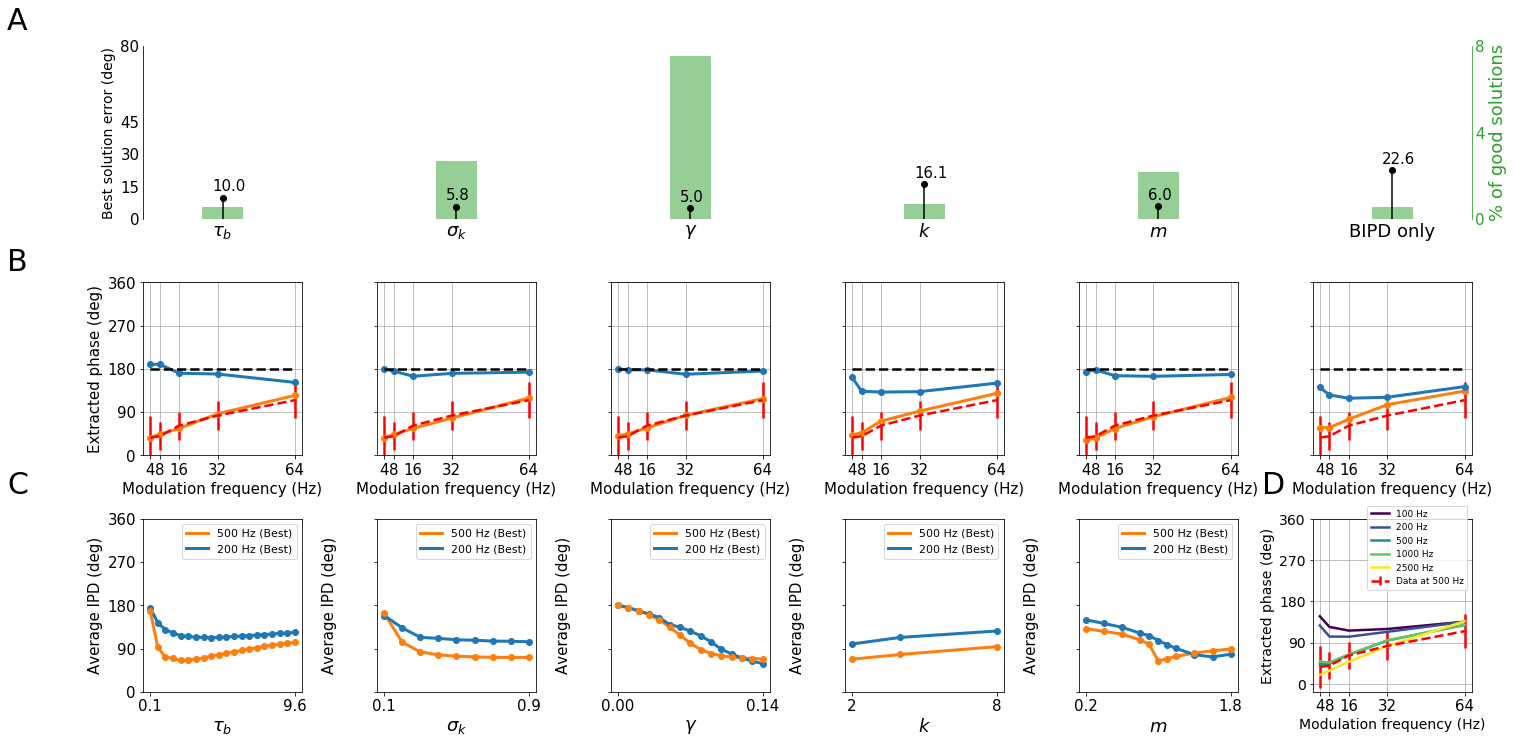

In [13]:
fig_carrier_pop('phase_500.npy','phase_200.npy','carriers.npy',dict_param,latex_param_names)